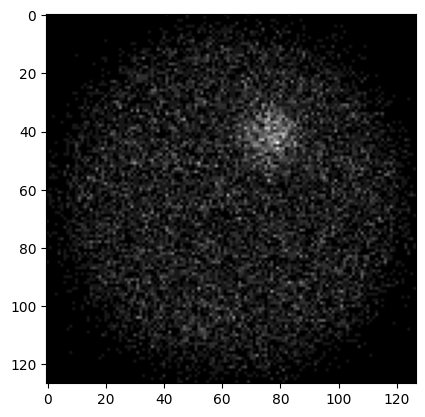

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import blur
from PIL import Image

device = "cuda"

k_size = 63
k_std = 6.0
n_std = 0.1
n_rate = 0.05

# Load the data
ref = Image.open('img/img_00.png').convert('L')

ref = torch.from_numpy(np.array(ref)).unsqueeze(0).unsqueeze(0).to(device).float() / 255.0
ref = ref[:, :, :-1, :-1]

gaussianblur = blur.GaussianBlur(k_size, k_std).to(device)
k_ref = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

noiser = noise.PoissonNoise(n_rate)
# noiser = noise.GaussianNoise(n_std)

# Blur the image
y = gaussianblur(ref)

# Add noise
y = noiser(y)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')

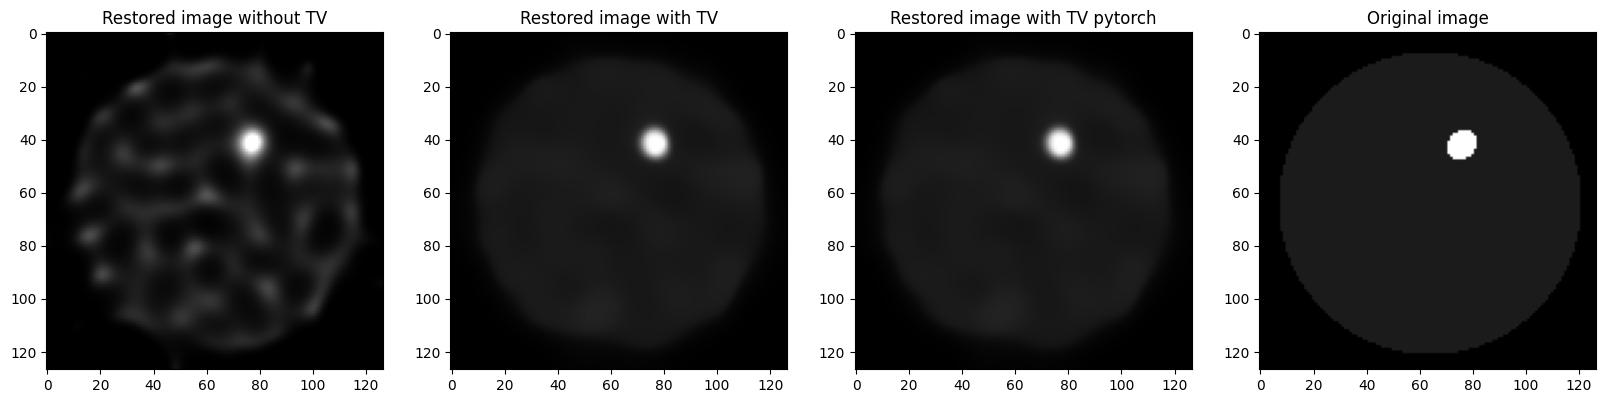

PSNR without TV:  26.09
PSNR with TV:  30.19
PSNR with TV pytorch:  30.19
SSIM without TV:  0.62
SSIM with TV:  0.86
SSIM with TV pytorch:  0.86


In [4]:
import torch.nn.functional as F
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 

x_0 = torch.ones_like(y) 
k = k_ref
observation = y

steps = 80
filter_epsilon = 1e-12
clip = True

with torch.no_grad():

    psf = k.clone().float()
    
    # For RGB images
    if(x_0.shape[1] == 3):
        psf = psf.repeat(1, 3, 1, 1)
        
    im_deconv = x_0.clone().float()
    k_T = torch.flip(psf, dims=[2, 3])  

    eps = 1e-12
    pad = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
    
    for _ in range(steps):
        conv = F.conv2d(F.pad(im_deconv, pad, mode='replicate'), psf) + eps
        if filter_epsilon:
            relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
        else:
            relative_blur = observation / conv
        im_deconv *= F.conv2d(F.pad(relative_blur, pad, mode='replicate'), k_T)

    if clip:
        im_deconv = torch.clamp(im_deconv, -1, 1)

with torch.no_grad():

    psf = k.clone().float()
    
    # For RGB images
    if(x_0.shape[1] == 3):
        psf = psf.repeat(1, 3, 1, 1)
        
    im_deconv_tv = x_0.clone().float()
    k_T = torch.flip(psf, dims=[2, 3])  

    eps = 1e-12
    pad = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
    
    for _ in range(steps):
        conv = F.conv2d(F.pad(im_deconv_tv, pad, mode='replicate'), psf) + eps
        if filter_epsilon:
            relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
        else:
            relative_blur = observation / conv
        im_deconv_tv *= F.conv2d(F.pad(relative_blur, pad, mode='replicate'), k_T)
        im_deconv_tv = torch.from_numpy(denoise_tv_chambolle(im_deconv_tv.cpu().numpy(), weight=0.5, max_num_iter=50, channel_axis=None)).to(device)

    if clip:
        im_deconv_tv = torch.clamp(im_deconv_tv, -1, 1)
        
with torch.no_grad():

    psf = k.clone().float()
    
    # For RGB images
    if(x_0.shape[1] == 3):
        psf = psf.repeat(1, 3, 1, 1)
        
    im_deconv_tv_torch = x_0.clone().float()
    k_T = torch.flip(psf, dims=[2, 3])  

    eps = 1e-12
    pad = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
    
    for _ in range(steps):
        conv = F.conv2d(F.pad(im_deconv_tv_torch, pad, mode='replicate'), psf) + eps
        if filter_epsilon:
            relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
        else:
            relative_blur = observation / conv
        im_deconv_tv_torch *= F.conv2d(F.pad(relative_blur, pad, mode='replicate'), k_T)
        im_deconv_tv_torch = rl.denoise_tv_chambolle_torch(im_deconv_tv_torch, weight=0.02, n_iter_max=50, multichannel=False)

    if clip:
        im_deconv_tv = torch.clamp(im_deconv_tv_torch, -1, 1)


plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(im_deconv[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Restored image without TV')
plt.subplot(1, 4, 2)
plt.imshow(im_deconv_tv[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Restored image with TV')
plt.subplot(1, 4, 3)
plt.imshow(im_deconv_tv_torch[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Restored image with TV pytorch')
plt.subplot(1, 4, 4)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original image')
plt.show()

psnr = peak_signal_noise_ratio(ref.detach().cpu().numpy(), im_deconv.detach().cpu().numpy())
psnr_tv = peak_signal_noise_ratio(ref.detach().cpu().numpy(), im_deconv_tv.detach().cpu().numpy())
psnr_tv_torch = peak_signal_noise_ratio(ref.detach().cpu().numpy(), im_deconv_tv_torch.detach().cpu().numpy())

ssim = structural_similarity(ref[0,0].detach().cpu().numpy(), im_deconv[0,0].detach().cpu().numpy(), data_range=1.0)
ssim_tv = structural_similarity(ref[0,0].detach().cpu().numpy(), im_deconv_tv[0,0].detach().cpu().numpy(),  data_range=1.0)
ssim_tv_torch = structural_similarity(ref[0,0].detach().cpu().numpy(), im_deconv_tv_torch[0,0].detach().cpu().numpy(),  data_range=1.0)

print("PSNR without TV: ", f"{psnr:.2f}")
print("PSNR with TV: ", f"{psnr_tv:.2f}")
print("PSNR with TV pytorch: ", f"{psnr_tv_torch:.2f}")
print("SSIM without TV: ", f"{ssim:.2f}")
print("SSIM with TV: ", f"{ssim_tv:.2f}")
print("SSIM with TV pytorch: ", f"{ssim_tv_torch:.2f}")

In [ ]:
ref.dtype

torch.float32

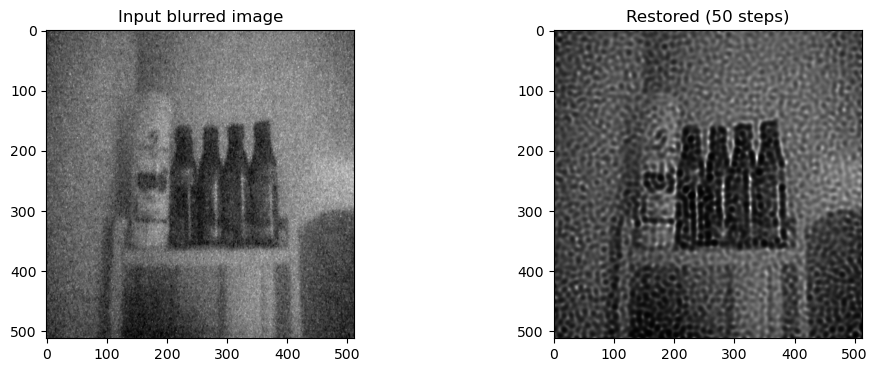

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image

# 让 Python 找到 src/ 里的 richardson_lucy.py
sys.path.append("src")
from algorithms.richardson_lucy import richardson_lucy

device = "cuda" if torch.cuda.is_available() else "cpu"

########################################################
# 1. 读取你的图像 img.png
########################################################
ref = Image.open('img/img.png').convert('L')  # ← 改成你的图像名字

ref = torch.from_numpy(np.array(ref)).unsqueeze(0).unsqueeze(0).float() / 255.0
ref = ref.to(device)

########################################################
# 2. 创建 PSF（你也可以换 motion blur）
########################################################
def gaussian_kernel(k=31, sigma=4):
    ax = torch.arange(k) - k // 2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    kernel = torch.exp(-(xx**2 + yy**2) / (2*sigma**2))
    kernel /= kernel.sum()
    return kernel[None, None, :, :]

k = gaussian_kernel(31, 4).to(device)

########################################################
# 3. 用你的图像直接作为 y（假设你的图是已经 blur 了的）
########################################################
y = ref.clone()

########################################################
# 4. RL 去卷积
########################################################
x0 = torch.ones_like(y)   # 初始猜测
steps = 50

deconv = richardson_lucy(y, x0, k, steps=steps, tv=False)

########################################################
# 5. 显示结果
########################################################
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(y[0, 0].cpu().numpy(), cmap='gray')
plt.title('Input blurred image')

plt.subplot(1, 2, 2)
plt.imshow(deconv[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title(f'Restored ({steps} steps)')
plt.show()
